# Introducción 

La idea de la práctica es visitar aquellos temas que en cierta manera nos permitan ver más contenido del curso.

La práctica esta dividida en 4 o 5 subapartados, que ya tenéis en este mismo Notebook. Estos subapartados estan aquí para que rellenéis el código que hace falta para la realización de la práctica. Obviamente podéis usar tantas celdas como os hagan falta, es más es de agradecer si el código final esta algo "limpio". Usar funciones, algo de comentario, etc, etc...

Usaremos 2 datasets, uno para el primer ejercicio, y otro para el resto de ejercicios.

Ejercicios:


1.   Machine Learning vs Deep Learning (Acordaros que hay que implementar el pipeline visto en clase entero)

    1.1. Implementación de un modelo de Sentiment Analysis con algún algoritmo de Machine Learning Clásico.
    
    1.2. Implementación de un modelo de Sentiment Analysis con alguna arquitectura de Deep Learning.
    
    1.3. Breve Comparación de resultados. Confusion Matrix.
    
2. Hacer Analysis de los tweets del segundo dataset. Que temas aparecen? Como se representan estos temas? De que hablan unos y otros?

3. Escoged a uno de los dos presidentes, y escribid tweets como ellos, usando un Modelo Generativo.

En cada ejercicio, espero explicaciones y razonamientos del porque una arquitectura y no otra, por ejemplo en Deep Learning, porque usar Convolutionals en lugar de recurrentes, o en Machine Learning, Bayes en lugar de SVM. Hay que explicar el pipeline, sobretodo el preproceso de datos, con lo que habrá que hacer un pequeño estudio de que datos tenemos, y si hay cosas que se pueden ignorar, si hacéis stemming, o no, etc, etc...

Acordaros de que objetivo final no es que obtengáis una accuracy brutal, es que comprendais que pasa cuando usais un algoritmo u otro, y que problemas o beneficios nos dan.

![](https://i.pinimg.com/736x/19/63/8c/19638c0b33e2f7822d6806ce31d89d84--funny-cartoons-funny-jokes.jpg)

Mucha suerte y ánimo!



In [4]:
# instalamos el software necesario
!pip install spacy
!python -m spacy download en_core_web_md

!pip install gensim
!pip install pyLDAvis
!pip install stop_words

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
     |████████████████████████████████| 1.6MB 25.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=c9e869f9d8f6df1c113fe28fd2131fd36d5c7ab3f2f9ece94104877381f036d7
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32916 sha256=24cf38fe2faf3451a013ef0d3b1e1915de8e74d0114df4645ba36d38feb069b6
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [93]:
# Hacemos los imports 
import numpy as np
from numpy import array
import pandas as pd
import re

import spacy
from spacy import displacy

import pickle
from joblib import dump, load

import gensim
from os.path import join
import csv
from stop_words import get_stop_words
from string import punctuation
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import io
from gensim.corpora import Dictionary
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel

import nltk
nltk.download("wordnet")
from nltk.corpus import stopwords
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

from collections import Counter

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, SimpleRNN, LSTM, Dense, Dropout, CuDNNLSTM,  GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Flatten, Input
from keras.models import load_model
from keras.utils import to_categorical


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Descargamos los datasets
# Tengo subidos los ficheros a repositorio de github para subirlos al notebook de forma más sencilla
!wget https://github.com/ivanrumo/KC_Practica_NLP/raw/master/datasets/train_sentiment_utf8.csv
!wget https://github.com/ivanrumo/KC_Practica_NLP/raw/master/datasets/dataset2.json
!wget https://github.com/ivanrumo/KC_Practica_NLP/raw/master/datasets/realDonaldTrump.json


--2019-09-22 12:21:38--  https://github.com/ivanrumo/KC_Practica_NLP/raw/master/datasets/train_sentiment_utf8.csv
Resolving github.com (github.com)... 52.74.223.119
Connecting to github.com (github.com)|52.74.223.119|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ivanrumo/KC_Practica_NLP/master/datasets/train_sentiment_utf8.csv [following]
--2019-09-22 12:21:39--  https://raw.githubusercontent.com/ivanrumo/KC_Practica_NLP/master/datasets/train_sentiment_utf8.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8703213 (8.3M) [text/plain]
Saving to: ‘train_sentiment_utf8.csv.1’

train_sentiment_utf 100%[===================>]   8.30M  --.-KB/s    in 0.04s   

2019-09-22 12:21:41 (209 MB/s) - ‘train_se

# Dataset

Breve explicación del dataset

In [7]:
df_sentiment = pd.read_csv('train_sentiment_utf8.csv')
df_sentiment.head(20)

,ï»¿ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
5,6,0,or i just worry too much?
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,8,0,Sunny Again Work Tomorrow :-| ...
8,9,1,handed in my uniform today . i miss you ...
9,10,1,hmmmm.... i wonder how she my number @-)


A simple vista y en unas pocas líneas vemos que hay algunas cosas que limpiar. Simbolos, emoticonos, expresiones coloquiales, abreviaturas, etc.

In [8]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
ï»¿ItemID        99989 non-null int64
Sentiment        99989 non-null int64
SentimentText    99989 non-null object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


Vemos que nuestro dataframe tiene casi 100.000 filas y que no tenemos valores nulos

In [9]:
df_sentiment['Sentiment'].value_counts()

1    56457
0    43532
Name: Sentiment, dtype: int64

Vemos que el dataset está bastante balanceado

Vamos procesar los emojis.

Me he basado un poco en este código:
https://github.com/Carmezim/crypto-twitter-sentiment-analysis/blob/master/preprocess.py

Básicamente he copiado y adaptado la función handle_emojis

In [0]:
# 
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', 'smile', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', 'laugh', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', 'love', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', 'wink', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', 'sad', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', 'cry', tweet)
    return tweet
  
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: handle_emojis(tweet))


Ahora vamos a reemplazar las contracciones.

En este artículo tienen ya un diccionario con contracciones y sus equivalencias que me va a venir muy bien:
https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

def replaceContraction(tweet):
  for w in tweet.split():
    if w.lower() in contraction_mapping:
      tweet = tweet.replace(w, contraction_mapping[w.lower()])
  return(tweet)

df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: replaceContraction(tweet))

Continuamos con la limpieza. Voy a utilizar expresiones regulares realizar varias labores de limpieza como caracteres especiales, 

In [0]:
# Remove all the special characters
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: re.sub(r'\W', ' ', tweet))

# remove all single characters
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet))

# Remove single characters from the start
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: re.sub(r'\^[a-zA-Z]\s+', ' ', tweet))

# Substituting multiple spaces with single space
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: tweet.strip(' "\''))

# Converting to Lowercase
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: tweet.lower())

# Replaces URLs
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet))

# Replace @handle
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: re.sub(r'@[\S]+', '', tweet))

# Replaces #hashtag with hashtag
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: re.sub(r'#(\S+)', r' \1 ', tweet))

# Remove RT (retweet)
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: re.sub(r'\brt\b', '', tweet))

# Replace 2+ dots with space
df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: re.sub(r'\.{2,}', ' ', tweet))


In [13]:
df_sentiment.head(20)

,ï»¿ItemID,Sentiment,SentimentText
0,1,0,is so sad for my apl friend
1,2,0,missed the new moon trailer
2,3,1,omg its already 7 30 o
3,4,0,omgaga im sooo im gunna cry have been at thi...
4,5,0,think mi bf is cheating on me t_t
5,6,0,or just worry too much
6,7,1,juuuuuuuuuuuuuuuuussssst chillin
7,8,0,sunny again work tomorrow tv...
8,9,1,handed in my uniform today miss you already
9,10,1,hmmmm wonder how she my number


Ya se va viendo los datos más limpitos, pero todavía tenemos algunas cosas, como por ejemplo abreviaturas omg (oh  my God) o bf (boy friend)
[En este repositorio](https://github.com/Deffro/text-preprocessing-techniques) tienen [un fichero](https://github.com/Deffro/text-preprocessing-techniques/blob/master/slang.txt) con unas cuantas abreviaturas en inglés y sus correspondencias que voy a usar.

In [14]:
!wget https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt
df_abrevations = pd.read_csv("slang.txt", header=None, delimiter="\t")
df_abrevations.columns = ['Abbreviation', 'Text']
abrevations_dict = dict([(Abbreviation, Text) for Abbreviation, Text in zip(df_abrevations.Abbreviation, df_abrevations.Text)])
abrevations_dict

--2019-09-22 12:21:54--  https://raw.githubusercontent.com/Deffro/text-preprocessing-techniques/master/slang.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5181 (5.1K) [text/plain]
Saving to: ‘slang.txt’

slang.txt           100%[===================>]   5.06K  --.-KB/s    in 0s      

2019-09-22 12:21:54 (71.2 MB/s) - ‘slang.txt’ saved [5181/5181]



{'2day': 'today',
 '2nite': 'tonight',
 '4u': 'for you',
 '4ward': 'forward',
 'a/n': 'author note',
 'a/s/l': 'age, sex, location',
 'a/w': 'anyway',
 'a3': 'anyplace, anywhere, anytime',
 'adn': 'any day now',
 'afaic': "as far as i'm concerned",
 'afaik': 'as far as I know',
 'afk': 'away from keyboard',
 'aggro': 'aggresive',
 'aight': 'alright',
 'airhead': 'stupid',
 'aka': 'as known as',
 'alol': 'actually laughing out loud',
 'amigo': 'friend',
 'amz': 'amazing',
 'app': 'application',
 'armpit': 'undesirable',
 'asap': 'as soon as possible',
 'atm': 'at the moment',
 'atw': 'all the way',
 'b-day': 'birthday',
 'b/c': 'because',
 'b4': 'before',
 'b4n': 'bye for now',
 'bae': 'before anyone else',
 'bak': 'back at the keyboard',
 'bbl': 'bee back later',
 'bday': 'birthday',
 'becuz': 'because',
 'bent': 'angry',
 'bestie': 'best friend',
 'besty': 'best friend',
 'bf': 'boyfriend',
 'bff': 'best friends forever',
 'bffe': 'best friends forever',
 'bfn': 'bye for now',
 'bg': 

In [0]:

def replaceAbrevations(tweet):
  for w in tweet.split():
    if w.lower() in abrevations_dict:
      tweet = tweet.replace(w, abrevations_dict[w.lower()])
  return(tweet)

df_sentiment['SentimentText'] = df_sentiment['SentimentText'].apply(lambda tweet: replaceAbrevations(tweet))

In [16]:
df_sentiment.head(20)

,ï»¿ItemID,Sentiment,SentimentText
0,1,0,is so sad for my apl friend
1,2,0,missed the new moon trailer
2,3,1,oh my god its already 7 30 o
3,4,0,omgaga im sooo im gunna cry have been at thi...
4,5,0,think mi boyfriend is cheating on me t_t
5,6,0,or just worry too much
6,7,1,juuuuuuuuuuuuuuuuussssst chillin
7,8,0,sunny again work tomorrow tv...
8,9,1,handed in my uniform today miss you already
9,10,1,hmmmm wonder how she my number


Ya tenemos el dataset mas limpio y preparado para procesarlo.


# Práctica/Código a entregar

## Pre-train Sentiment Analysis Model

## Sentiment Analysis with Politics

### Machine learning clásico



#### Bayes

Vamos a empezar con Bayes para este problema de clasificación. Para poder probar con diferentes valores para los parámetros del modelo voy a montarlo con un pipeline

Dividimos el dataset en los conjuntos de entrenamiento y de test

In [0]:
X = df_sentiment['SentimentText']
y = df_sentiment['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Definimos la arquitectura de nuestro modelo

In [0]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', MultinomialNB()),
])
pipeline.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__alpha', 'clf__class_prior', 'clf__fit_prior'])

In [0]:
parameters = {
    'vect__min_df': (2, 3),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 3), (1,4)),    
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  7.0min finished


	vect__max_df: 0.5
	vect__min_df: 3
	vect__ngram_range: (1, 2)
Best score: 0.769


In [0]:
pipeline.set_params(**best_parameters)
predictions = pipeline.score(X_test, y_test)
print('TEST SCORE: {}'.format(predictions))

TEST SCORE: 0.7747274727472747



Tanto con el conjunto de entrenamiento como con el conjunto de test obtenemos un 0.77. Nada de overfiting :)

In [0]:
# Guardamos el modelo
bayes_persist = dict({
    'model': pipeline,
    'metadata': {
        'name': 'Bayes',
        'author': 'Ivan Rubio',
        'date': '2019-09-20T22:45:00CEST',
        'source_code_version': '1.0',
        'metrics': {
            'accuracy': 0.77
        }
    }
})
dump(bayes_persist, 'bayes.joblib')


['bayes.joblib']

#### Support Vector Machines

Ahora probamos con SVM ya que se supone puede arrojar mejores resultados.


In [0]:
pipelineSVM = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', LinearSVC()),
])

parametersSVM = {
    'vect__min_df': (2, 3),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 3), (1,4)),
    'clf__C': (0.1, 0.5, 1),
}

grid_searchSVM = GridSearchCV(pipelineSVM, parametersSVM, n_jobs=-1, verbose=1)

grid_searchSVM.fit(X_train, y_train)
best_parameters = grid_searchSVM.best_estimator_.get_params()
for param_name in sorted(parametersSVM.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Best score: %0.3f" % grid_searchSVM.best_score_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 21.7min finished


	clf__C: 0.1
	vect__max_df: 0.5
	vect__min_df: 3
	vect__ngram_range: (1, 2)
Best score: 0.779


In [0]:
pipelineSVM.set_params(**best_parameters)
predictions = pipelineSVM.score(X_test, y_test)
print('Test acc score: {}'.format(predictions))

Test acc score: 0.7811281128112811


In [0]:
# Guardamos el modelo
SVM_persist = dict({
    'model': pipelineSVM,
    'metadata': {
        'name': 'SVM',
        'author': 'Ivan Rubio',
        'date': '2019-09-20T23:50:00CEST',
        'source_code_version': '1.0',
        'metrics': {
            'accuracy': 0.78
        }
    }
})
dump(SVM_persist, 'SVM.joblib')

['SVM.joblib']

Hemos mejorado levemente los resultados respecto a Bayes. 

Realmente no se si merece la pena una mejora de 0.01 respecto al aumento de gasto de recursos. Con Bayes hemos entrenado el modelo en 10 minutos y con SVM hemos tardado más de media hora. Creo que no compensa

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


### Deep Learning

Vamos a empezar con una CNN para ver que resultados nos da.


In [17]:
# obtenemos el numero de features
count_words = Counter(" ".join(df_sentiment['SentimentText'].values.tolist()).split(" ")).items()
max_features = len(count_words)
max_features

106348

In [18]:
count_words

dict_items([('is', 21334), ('so', 9228), ('sad', 1628), ('for', 12661), ('my', 15165), ('apl', 2), ('friend', 798), ('missed', 700), ('the', 30798), ('new', 1826), ('moon', 97), ('trailer', 59), ('oh', 3676), ('god', 1151), ('its', 2539), ('already', 879), ('7', 265), ('30', 288), ('', 227408), ('o', 139), ('omgaga', 1), ('im', 2978), ('sooo', 273), ('gunna', 52), ('cry', 376), ('have', 12513), ('been', 2226), ('at', 5416), ('this', 4769), ('dentist', 38), ('since', 569), ('11', 138), ('was', 7627), ('suposed', 1), ('2', 2221), ('just', 6934), ('get', 5329), ('crown', 11), ('put', 538), ('on', 9749), ('30mins', 5), ('think', 2886), ('mi', 40), ('boyfriend', 154), ('cheating', 17), ('me', 11314), ('t_t', 9), ('or', 2452), ('worry', 214), ('too', 5264), ('much', 2265), ('juuuuuuuuuuuuuuuuussssst', 1), ('chillin', 53), ('sunny', 148), ('again', 1392), ('work', 2637), ('tomorrow', 1172), ('tv', 322), ('tonight', 1024), ('handed', 24), ('in', 11975), ('uniform', 10), ('today', 2607), ('miss

In [0]:
# creo el tokenizer con las palabras de los tweets
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_sentiment['SentimentText'].values)

In [0]:
# creamos los conjuntos de entrenamiento y de test
max_tweets = df_sentiment.shape[0] # 50000 # 10000
X = tokenizer.texts_to_sequences(df_sentiment['SentimentText'].values[:max_tweets])
X = pad_sequences(X)

y = pd.get_dummies(df_sentiment['Sentiment'][:max_tweets]).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
df_sentiment.shape[0]

99989

In [0]:
batch_size = 32

rnn_type = SimpleRNN(100)

input_layer = Input(shape=(X.shape[1],))
embedding = Embedding(output_dim=100, input_dim=max_features, input_length=X.shape[1])(input_layer)
doc_representation = rnn_type(embedding)
dense_1 = Dense(300, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(300, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(2, activation='softmax')(drop_2)

model = Model(input=input_layer, output=out)
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 188)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 188, 100)          10634800  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               30300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
____

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [0]:
model.fit(X_train, y_train, batch_size = batch_size, epochs = 10)
model.save('lstm1.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
79991/79991 [==============================] - 409s 5ms/step - loss: 0.5603 - acc: 0.7108
Epoch 2/10
79991/79991 [==============================] - 402s 5ms/step - loss: 0.4886 - acc: 0.7723
Epoch 3/10
79991/79991 [==============================] - 399s 5ms/step - loss: 0.4616 - acc: 0.7920
Epoch 4/10
79991/79991 [==============================] - 395s 5ms/step - loss: 0.4004 - acc: 0.8316
Epoch 5/10
79991/79991 [==============================] - 387s 5ms/step - loss: 0.3335 - acc: 0.8702
Epoch 6/10
79991/79991 [==============================] - 392s 5ms/step - loss: 0.2976 - acc: 0.8878
Epoch 7/10
79991/79991 [==============================] - 397s 5ms/step - loss: 0.2719 - acc: 0.9001
Epoch 8/10
79991/79991 [==============================] - 386s 5ms/step - loss: 0.2511 - acc: 0.9091
Epoch 9/10
79991/79991 [==============================] - 394s 5ms/step - loss: 0.2329 - acc: 0.91

In [0]:
model = load_model('lstm1.h5')
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 67.51%


Con 10 épocas conseguimos un accuracy del 67%. Parece que el modelo tiene mucho overfiting


In [0]:
rnn_type = SimpleRNN(100)

input_layer = Input(shape=(X.shape[1],))
embedding = Embedding(output_dim=100, input_dim=max_features, input_length=X.shape[1])(input_layer)

conv_1 = Conv1D(filters=50, kernel_size=1, strides=1, activation='relu', padding='valid')(embedding)
mp_1 = GlobalMaxPooling1D()(conv_1)

conv_2 = Conv1D(filters=50, kernel_size=2, strides=1, activation='relu', padding='valid')(embedding)
mp_2 = GlobalMaxPooling1D()(conv_2)

conv_5 = Conv1D(filters=50, kernel_size=5, strides=1, activation='relu', padding='valid')(embedding)
mp_5 = GlobalMaxPooling1D()(conv_5)

doc_representation = rnn_type(embedding)
dense_1 = Dense(300, activation='relu')(doc_representation)
drop_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(300, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(dense_2)
out = Dense(2, activation='softmax')(drop_2)

model = Model(input=input_layer, output=out)
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'],
)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 188)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 188, 100)          10634800  
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_4 (Dense)              (None, 300)               30300     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
model.fit(X_train, y_train, batch_size = batch_size, epochs = 10)
model.save('lstm2.h5')

Epoch 1/10
79991/79991 [==============================] - 400s 5ms/step - loss: 0.5616 - acc: 0.7093
Epoch 2/10
79991/79991 [==============================] - 396s 5ms/step - loss: 0.5148 - acc: 0.7557
Epoch 3/10
79991/79991 [==============================] - 395s 5ms/step - loss: 0.4823 - acc: 0.7818
Epoch 4/10
79991/79991 [==============================] - 398s 5ms/step - loss: 0.4068 - acc: 0.8307
Epoch 5/10
79991/79991 [==============================] - 397s 5ms/step - loss: 0.3528 - acc: 0.8617
Epoch 6/10
79991/79991 [==============================] - 397s 5ms/step - loss: 0.3262 - acc: 0.8771
Epoch 7/10
79991/79991 [==============================] - 398s 5ms/step - loss: 0.3095 - acc: 0.8870
Epoch 8/10
79991/79991 [==============================] - 395s 5ms/step - loss: 0.2997 - acc: 0.8924
Epoch 9/10
79991/79991 [==============================] - 396s 5ms/step - loss: 0.2946 - acc: 0.8977
Epoch 10/10
79991/79991 [==============================] - 385s 5ms/step - loss: 0.2883 - a

In [0]:
model = load_model('lstm2.h5')
scores = model.evaluate(X_test, y_test, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 73.66%


Tenemos un accuracy del 73%. Seguimos con bastante overfiting, pero obtenemos mejores resultados, aunque no llegamos a los resultados obtenidos con machine learning. Con más épocas y tuneando los hyperparámetros posiblemente obtengamos mejores resultados. 



### Comparación modelos
Vamos a sacar las matrices de confusión

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


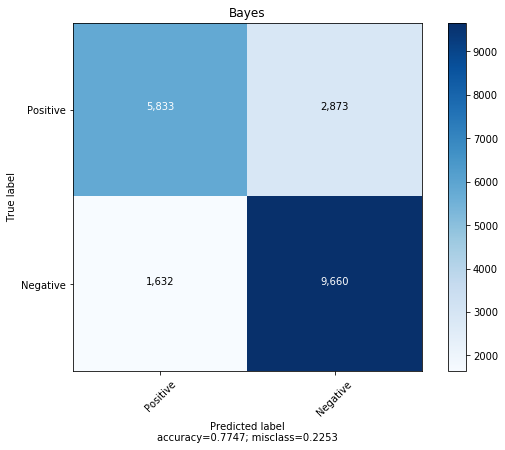

In [0]:
#bayes_model = load('bayes.joblib').get('model')
y_pred = bayes_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm           = np.array(cm), 
                      normalize    = False,
                      target_names = ['Positive', "Negative"],
                      title        = "Bayes")



In [31]:
#!wget https://github.com/ivanrumo/KC_Practica_NLP/blob/master/lstm2.h5?raw=true -O lstm2.h5
#lstm_model = load_model('lstm2.h5')
y_pred = lstm_model.predict(X_test)
y_pred
#cm = confusion_matrix(y_test, y_pred)
#cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()


#plot_confusion_matrix(cm           = np.array(cm), 
#                      normalize    = False,
#                      target_names = ['Positive', "Negative"],
#                      title        = "Bayes")



'\nplot_confusion_matrix(cm           = np.array(cm), \n                      normalize    = False,\n                      target_names = [\'Positive\', "Negative"],\n                      title        = "Bayes")\n'

Lamentandolo mucho, no consigo obtener la matriz de confuxión del modelo de deeplearning y tengo que entregar ya la práctica. 

## Tweet Analysis

### Exploración y limpieza del dataset

Como en el ejercicio anterior cargamos el dataset, hacemos una pequeña exploración y limpiamos y hacemos las transformaciones necesarias antes de entrenar nuestro modelo

In [264]:
df_presidents = pd.read_json('dataset2.json', orient='index')
df_presidents.head(20)

,label,tweet
0,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
1,OBAMA,"“Low plastic stool, cheap but delicious noodle..."
2,OBAMA,"This National Gun Violence Awareness Day, show..."
3,OBAMA,We can never truly repay the debt we owe our f...
4,OBAMA,This Center is for the leaders of tomorrow who...
5,OBAMA,"Happy Mother’s Day to every mom out there, esp..."
6,OBAMA,There are few issues more important to the sec...
7,OBAMA,These talented young people will create a bett...
8,OBAMA,Our statement on the passing of Former First L...
9,OBAMA,Incredible to have a Chicago team in the Final...


In [266]:
df_presidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5889 entries, 0 to 5888
Data columns (total 2 columns):
label    5889 non-null object
tweet    5889 non-null object
dtypes: object(2)
memory usage: 138.0+ KB


In [267]:
df_presidents['label'].value_counts()

TRUMP    2995
OBAMA    2894
Name: label, dtype: int64

Vemos que los textos son más formalmente correctos, aunque se pueden apreciar simbolos y caracteres a limpiar.

Vamos a preparar los datos con ayuda de spacy y stop_words

In [0]:
# Remove all the special characters
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'\W', ' ', tweet))

# remove all single characters
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet))

# Remove single characters from the start
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'\^[a-zA-Z]\s+', ' ', tweet))

# Substituting multiple spaces with single space
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: tweet.strip(' "\''))

# Converting to Lowercase
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: tweet.lower())

# Replaces URLs
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet))
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'((www\.[\S]+)|(http?://[\S]+))', '', tweet))
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'http\S+', '', tweet))

# Replace @handle
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'@[\S]+', '', tweet))

# Replaces #hashtag with hashtag
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'#(\S+)', r' \1 ', tweet))

# Remove RT (retweet)
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'\brt\b', '', tweet))

# Replace 2+ dots with space
df_presidents['tweet'] = df_presidents['tweet'].apply(lambda tweet: re.sub(r'\.{2,}', ' ', tweet))

In [272]:
df_presidents.tail(20)

,label,tweet
5869,TRUMP,spoke to k prime minister theresa may today t...
5870,TRUMP,spoke to k prime minister theresa may today t...
5871,TRUMP,big day for healthcare working hard
5872,TRUMP,today on nationalagday we honor our great am...
5873,TRUMP,honored to sign 442 today with this legislati...
5874,TRUMP,joined the housegop conference this morning a...
5875,TRUMP,thank you louisville kentucky together we w...
5876,TRUMP,thank you louisville kentucky on my way ma...
5877,TRUMP,congratulations eric amp lara very proud an...
5878,TRUMP,what about all of the contact with the clinton...


In [0]:
stop_words = get_stop_words('en') + list(punctuation) + [' ']
nlp = spacy.load('en_core_web_sm')

documents = []
for row in df_presidents.iterrows():
    _, info = row
    _, q = info
    q = re.sub(r'\n', '', q)
    q = [t.text for t in nlp(q.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    documents.append(q)

In [240]:
gensim_dict = Dictionary(documents)
#gensim_dict.filter_extremes(no_below=2, no_above=0.3)
len(gensim_dict)

11764

In [0]:
corpus = [gensim_dict.doc2bow(doc) for doc in documents]

In [0]:
# con este método evaluamos diferentes modelos
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, 
                                  random_state=42, eval_every=10, chunksize=2000, 
                                  passes=20, iterations=5, 
                                  per_word_topics=True, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity



In [0]:
limit=25; start=2; step=2;
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=gensim_dict, corpus=corpus, texts=documents, start=start, limit=limit, step=step)


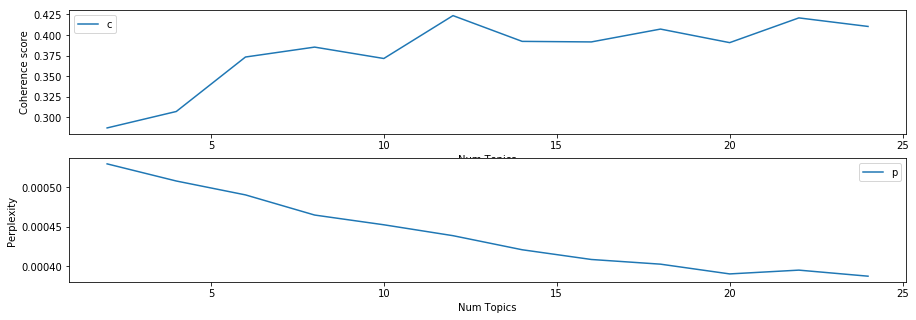

In [243]:
x = range(start, limit, step)

plt.figure(figsize=(15, 5))

plt.subplot(211)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.subplot(212)
plt.plot(x, np.exp(perplexity_values))
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("perplexity_values"), loc='best')

plt.show()

Según el gráfico el mejor resultado es con 20 topics. Quizá un número algo alto y veo muy factible que se mezclen algunos de los topics. Voy a probar con 12 que la segunda mejor opción.

Vamos a ver el grafico de clustering


In [219]:
model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=12, iterations=5, passes=20, alpha='auto')
vis = pyLDAvis.gensim.prepare(model, corpus, gensim_dict)
pyLDAvis.display(vis)

A la vista del gráfico se puede ver que hay muchos topics que se solapan

In [236]:
model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=20, iterations=5, passes=20, alpha='auto')
topics = model.print_topics(num_words=4)
for topic in topics:
  print(topic)

(0, '0.080*"co" + 0.079*"president" + 0.065*"obama" + 0.061*"http"')
(1, '0.042*"rate" + 0.031*"itsonus" + 0.024*"sexual" + 0.022*"assault"')
(2, '0.091*"co" + 0.069*"http" + 0.044*"  " + 0.024*"2015"')
(3, '0.077*"co" + 0.049*"http" + 0.037*"health" + 0.029*"https"')
(4, '0.098*"https" + 0.086*"co" + 0.036*"doyourjob" + 0.036*"senate"')
(5, '0.047*"co" + 0.043*"http" + 0.041*"great" + 0.039*"economic"')
(6, '0.046*"co" + 0.023*"http" + 0.023*"https" + 0.023*"state"')
(7, '0.052*"co" + 0.050*"president" + 0.048*"http" + 0.043*"obama"')
(8, '0.065*"co" + 0.051*"http" + 0.043*"day" + 0.012*"every"')
(9, '0.089*"co" + 0.063*"name" + 0.060*"add" + 0.053*"http"')
(10, '0.097*"co" + 0.070*"http" + 0.039*"care" + 0.037*"health"')
(11, '0.029*"ve" + 0.028*"know" + 0.025*"got" + 0.019*"two"')
(12, '0.134*"co" + 0.107*"http" + 0.026*"take" + 0.020*"stand"')
(13, '0.090*"co" + 0.063*"http" + 0.024*"ofa" + 0.024*"https"')
(14, '0.159*"president" + 0.157*"obama" + 0.128*"   " + 0.023*"america"')
(1

En algunos topics se puede intuir de que se habla incluso quien es el autor. Por ejemplo los topic 8 y 9 parecen claramente de Trump. Otros sin embargo se entremezclan

Voy ha hacer el mismo análisis, pero de los dos presidentes por separado.

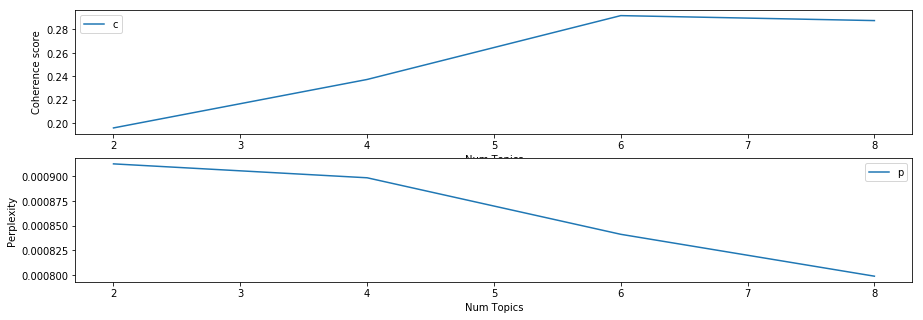

In [244]:
documents = []
for q in df_presidents[df_presidents['label']=="OBAMA"]['tweet']:    
    q = [t.text for t in nlp(q.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    documents.append(q)

gensim_dict = Dictionary(documents)
corpus = [gensim_dict.doc2bow(doc) for doc in documents]
limit=10; start=2; step=2;
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=gensim_dict, corpus=corpus, texts=documents, start=start, limit=limit, step=step)

x = range(start, limit, step)

plt.figure(figsize=(15, 5))

plt.subplot(211)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.subplot(212)
plt.plot(x, np.exp(perplexity_values))
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("perplexity_values"), loc='best')

plt.show()


In [246]:
model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=6, iterations=5, passes=20, alpha='auto')
vis = pyLDAvis.gensim.prepare(model, corpus, gensim_dict)
pyLDAvis.display(vis)

In [273]:
topics = model.print_topics(num_words=8)
for topic in topics:
  print(topic)

(0, '0.117*"co" + 0.090*"http" + 0.029*"  " + 0.023*"actonclimate" + 0.020*"change" + 0.017*"climate" + 0.013*"live" + 0.011*"ofa"')
(1, '0.084*"co" + 0.060*"  " + 0.026*"http" + 0.025*"health" + 0.016*"getcovered" + 0.014*"care" + 0.012*"add" + 0.012*"doyourjob"')
(2, '0.112*"president" + 0.107*"obama" + 0.065*"   " + 0.012*"america" + 0.011*"immigrationaction" + 0.011*"sotu" + 0.009*"work" + 0.009*"can"')
(3, '0.046*"http" + 0.038*"co" + 0.020*"watch" + 0.018*"m" + 0.016*"et" + 0.015*"tune" + 0.014*"middle" + 0.014*"class"')
(4, '0.022*"http" + 0.021*"jobs" + 0.020*"co" + 0.017*"growth" + 0.016*"year" + 0.014*"news" + 0.013*"great" + 0.013*"economy"')
(5, '0.077*"co" + 0.054*"http" + 0.031*"time" + 0.024*"  " + 0.016*"now" + 0.012*"address" + 0.012*"weekly" + 0.009*"watch"')


Obviamente algo en la limpieza no lo he hecho bien. 

Según el gráfico los topics 0, 1 y 3 están muy solapados, sin embargo parece que el topic 0 se refiere al cambio climático, el punto 1 a la salud y el punto 3 no lo tengo muy claro.

El punto 2 parece que habla de la inmigración.

El punto 4 de trabajo y economía

Y el punto 5 tampoco está muy claro.

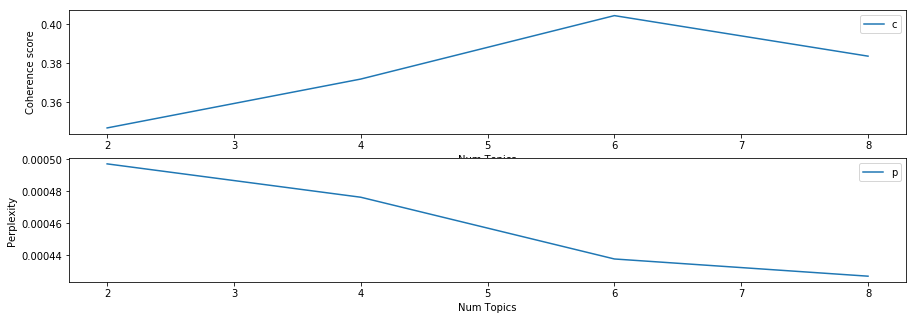

In [245]:
documents = []
for q in df_presidents[df_presidents['label']=="TRUMP"]['tweet']:    
    q = [t.text for t in nlp(q.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    documents.append(q)

gensim_dict = Dictionary(documents)
corpus = [gensim_dict.doc2bow(doc) for doc in documents]
limit=10; start=2; step=2;
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=gensim_dict, corpus=corpus, texts=documents, start=start, limit=limit, step=step)

x = range(start, limit, step)

plt.figure(figsize=(15, 5))

plt.subplot(211)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.subplot(212)
plt.plot(x, np.exp(perplexity_values))
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("perplexity_values"), loc='best')

plt.show()

In [247]:
model = models.LdaModel(corpus, id2word=gensim_dict, num_topics=6, iterations=5, passes=20, alpha='auto')
vis = pyLDAvis.gensim.prepare(model, corpus, gensim_dict)
pyLDAvis.display(vis)

In [275]:
topics = model.print_topics(num_words=4)
for topic in topics:
  print(topic)

(0, '0.022*"will" + 0.018*"amp" + 0.013*"  " + 0.009*"korea"')
(1, '0.044*"today" + 0.043*"well" + 0.042*"strong" + 0.040*"minister"')
(2, '0.025*"great" + 0.024*"  " + 0.014*"will" + 0.012*"make"')
(3, '0.012*"great" + 0.011*"will" + 0.008*"win" + 0.008*"people"')
(4, '0.026*"  " + 0.023*"news" + 0.021*"fake" + 0.015*"jobs"')
(5, '0.093*"co" + 0.079*"  " + 0.021*"great" + 0.015*"thank"')


como en el caso de Obama el gráfico muestra algunos topics bastante solapados. Aunque mostrando los primeros terminos no lo parecen tanto

El topic 0 parece que habla de política exterior

El topic 1 trata de agún primer ministro

El topic 2 se refiere a america 

El topic 3 no me queda muy claro 

El topic 4 va de noticias falsas

El topic 5 no está muy claro tampoco


## Tweet Generation

Primero cargamos los tweets del presidente Trump y hacemos una pequeña exploración y limpieza

In [193]:
df_trump = pd.read_json('realDonaldTrump.json', typ='series')
df_trump.head(10)

0    My thoughts and prayers are with the families ...
1    My thoughts and prayers are with the families ...
2    I am heading for Canada and the G-7 for talks ...
3    Congratulations to the Washington Capitals on ...
4    Looking forward to straightening out unfair Tr...
5    Canada charges the U.S. a 270%  tariff on Dair...
6    Obama, Schumer and Pelosi did NOTHING about No...
7    Why isn’t the European Union and Canada inform...
8    Prime Minister Trudeau is being so indignant, ...
9    Please tell Prime Minister Trudeau and Preside...
dtype: object

In [194]:
df_trump.shape

(2995,)

In [0]:
df_trump.drop_duplicates()

# Remove all the special characters
df_trump = df_trump.apply(lambda tweet: re.sub(r'\W', ' ', tweet))

# Substituting multiple spaces with single space
df_trump = df_trump.apply(lambda tweet: tweet.strip(' "\''))

# Replaces URLs
df_trump = df_trump.apply(lambda tweet: re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet))

# Replace @handle
df_trump = df_trump.apply(lambda tweet: re.sub(r'@[\S]+', '', tweet))

# Replaces #hashtag with hashtag
df_trump = df_trump.apply(lambda tweet: re.sub(r'#(\S+)', r' \1 ', tweet))

# Remove RT (retweet)
df_trump = df_trump.apply(lambda tweet: re.sub(r'\brt\b', '', tweet))

# Replace 2+ dots with space
df_trump = df_trump.apply(lambda tweet: re.sub(r'\.{2,}', ' ', tweet))

In [0]:
stop_words = get_stop_words('en') + list(punctuation) + [' ']
nlp = spacy.load('en_core_web_sm')

documents = []
for q in df_trump:    
    q = [t.text for t in nlp(q.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]    
    documents.append(q)

texts = ""
for text in documents:
  texts = texts + ' '.join(text) + '\n'


### One-Word-In, One-Word-Out Sequences

Vamos a probar con un modelo One-Word-In, One-Word-Out Sequences

Primero codificamos las palabras

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([texts])
encoded = tokenizer.texts_to_sequences([texts])[0]

Obtenemos el tamaño del vocabulario. Agregamos uno, porque necesitaremos especificar el número entero para la palabra codificada más grande como un índice de matriz.

In [199]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7700


Ahora creo secuencias de palabras para entrenar el modelo con una palabra como entrada y una palabra como salida.

In [0]:
sequences = list()

for i in range(1, len(encoded)):
    sequence = (encoded[i-1], encoded[i])
    sequences.append(sequence) 
    
sequences = np.array(sequences)

X, y = sequences[:,0], sequences[:, 1]

Hago one hot enconding de la salida

In [0]:
y = to_categorical(y, num_classes=vocab_size)

Definimos el modelo

In [203]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 1, 10)             77000     
_________________________________________________________________
lstm_30 (LSTM)               (None, 50)                12200     
_________________________________________________________________
dense_21 (Dense)             (None, 7700)              392700    
Total params: 481,900
Trainable params: 481,900
Non-trainable params: 0
_________________________________________________________________
None


Y lo compilamos y entrenamos

In [168]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=50, verbose=2)
model.save('tweet_generation1.h5')

Epoch 1/50
 - 13s - loss: 7.6936 - acc: 0.0323
Epoch 2/50
 - 10s - loss: 7.2328 - acc: 0.0438
Epoch 3/50
 - 10s - loss: 7.1207 - acc: 0.0467
Epoch 4/50
 - 10s - loss: 7.0422 - acc: 0.0509
Epoch 5/50
 - 10s - loss: 6.9233 - acc: 0.0675
Epoch 6/50
 - 10s - loss: 6.7420 - acc: 0.0935
Epoch 7/50
 - 10s - loss: 6.5219 - acc: 0.1140
Epoch 8/50
 - 10s - loss: 6.3055 - acc: 0.1279
Epoch 9/50
 - 10s - loss: 6.1188 - acc: 0.1428
Epoch 10/50
 - 10s - loss: 5.9639 - acc: 0.1551
Epoch 11/50
 - 10s - loss: 5.8317 - acc: 0.1642
Epoch 12/50
 - 10s - loss: 5.7096 - acc: 0.1744
Epoch 13/50
 - 10s - loss: 5.5929 - acc: 0.1840
Epoch 14/50
 - 10s - loss: 5.4816 - acc: 0.1921
Epoch 15/50
 - 10s - loss: 5.3760 - acc: 0.1999
Epoch 16/50
 - 10s - loss: 5.2773 - acc: 0.2084
Epoch 17/50
 - 10s - loss: 5.1844 - acc: 0.2153
Epoch 18/50
 - 10s - loss: 5.0980 - acc: 0.2230
Epoch 19/50
 - 10s - loss: 5.0166 - acc: 0.2294
Epoch 20/50
 - 10s - loss: 4.9404 - acc: 0.2354
Epoch 21/50
 - 10s - loss: 4.8689 - acc: 0.2416
E

Creamos un función para generar los tweets con el modelo entrenado

In [0]:
# generate a sequence from the model
def generate_tweet(model, tokenizer, seed_text, n_words):
	in_text, result = seed_text, seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		encoded = array(encoded)
		# predict a word in the vocabulary
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text, result = out_word, result + ' ' + out_word
	return result



In [170]:
# elegimos una palabra al azar para empezar a generar el tweet
import random
word = documents[random.randint(0, len(documents))][0]

print(generate_tweet(model, tokenizer, word, 10))

together will great honor welcome prime minister theresa may today offer


### Line-by-Line Sequence
Palabra a palabra no es que genere tweets muy coherentes. Vamos a probar haciendo secuencias línea a línea. Digamos que por cada línea cogemos la primera palabra que será la entrada y la segunda palabra será la salida. Después cogemos las dos primeras palabras como la entrada y la tercera como la salida. Y así sucesivamente con cada línea.

Obviamente las secuencias de antes no nos valen y hay que crear unas que se ajunten al modelo línea a línea

In [171]:
sequences = list()
for line in texts.split('\n'):
	encoded = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(encoded)):
		sequence = encoded[:i+1]
		sequences.append(sequence)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 46144


A continuación, podemos rellenar las secuencias preparadas. Para ellos usamos la función pad_sequences() de Keras. Primero tenemos que encontrar la secuencia más larga y luego usarla como la longitud para completar todas las demás secuencias.

In [172]:
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)

Max Sequence Length: 39


ahora podemos dividir las secuencias en elementos de entrada y salida, como antes.

In [0]:
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

De nuevo definimos el modelo y lo entrenamos

In [174]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length-1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=50, verbose=2)
model.save('tweet_generation2.h5')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 38, 10)            76100     
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                12200     
_________________________________________________________________
dense_14 (Dense)             (None, 7610)              388110    
Total params: 476,410
Trainable params: 476,410
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 - 87s - loss: 7.6680 - acc: 0.0338
Epoch 2/50
 - 83s - loss: 7.1737 - acc: 0.0493
Epoch 3/50
 - 83s - loss: 6.9981 - acc: 0.0673
Epoch 4/50
 - 83s - loss: 6.8224 - acc: 0.0818
Epoch 5/50
 - 84s - loss: 6.6402 - acc: 0.0917
Epoch 6/50
 - 83s - loss: 6.4664 - acc: 0.0978
Epoch 7/50
 - 84s - loss: 6.3001 - acc: 0.1035
Epoch 8/50
 - 83s - loss: 6.1381 - acc: 0.1

In [175]:
def generate_tweet(model, tokenizer, max_length, seed_text, n_words):
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# pre-pad sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
	return in_text

word = documents[random.randint(0, len(documents))][0]
print(generate_tweet(model, tokenizer, max_length - 1, word, 10))

spoke k prime minister theresa may today offer condolences terrorist attack


### Two-Words-In, One-Word-Out Sequence

Podemos probar un modelo intermedio. Usaremos 3 palabras como entrada para predecir una palabra como salida.

Generamos las secuencias. Es muy parecido al primer modelo

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([texts])
encoded = tokenizer.texts_to_sequences([texts])[0]

sequences = list()
for i in range(2, len(encoded)):
	sequence = encoded[i-2:i+1]
	sequences.append(sequence)

El resto es igual que en el anterior modelo

In [205]:
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
print('Max Sequence Length: %d' % max_length)

Max Sequence Length: 3


In [0]:
sequences = array(sequences)
X, y = sequences[:,:-1],sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)

In [207]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length-1))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=50, verbose=2)
model.save('tweet_generation3.h5')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 2, 10)             77000     
_________________________________________________________________
lstm_31 (LSTM)               (None, 50)                12200     
_________________________________________________________________
dense_22 (Dense)             (None, 7700)              392700    
Total params: 481,900
Trainable params: 481,900
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 - 19s - loss: 7.5150 - acc: 0.0385
Epoch 2/50
 - 14s - loss: 7.0357 - acc: 0.0634
Epoch 3/50
 - 14s - loss: 6.8546 - acc: 0.0824
Epoch 4/50
 - 14s - loss: 6.6927 - acc: 0.1021
Epoch 5/50
 - 14s - loss: 6.5375 - acc: 0.1141
Epoch 6/50
 - 14s - loss: 6.3624 - acc: 0.1258
Epoch 7/50
 - 14s - loss: 6.1766 - acc: 0.1372
Epoch 8/50
 - 14s - loss: 5.9997 - acc: 0.1

In [263]:
word = documents[random.randint(0, len(documents))][0]
print(generate_tweet(model, tokenizer, max_length - 1, word, 6))

people august permanent men women united states


Voy a intentar mejorar el modelo. Voy a aumentar el número de neuronas de capa LSTM y voy ha añadir una capa Dropout

In [250]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length-1))
model.add(LSTM(256))
model.add(Dropout(0.1))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X, y, epochs=50, verbose=2)
model.save('tweet_generation4.h5')

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 2, 10)             77000     
_________________________________________________________________
lstm_33 (LSTM)               (None, 256)               273408    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 7700)              1978900   
Total params: 2,329,308
Trainable params: 2,329,308
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
 - 20s - loss: 7.3568 - acc: 0.0563
Epoch 2/50
 - 15s - loss: 6.8401 - acc: 0.0900
Epoch 3/50
 - 15s - loss: 6.6120 - acc: 0.1099
Epoch 4/50
 - 15s - loss: 6.3682 - acc: 0.1260
Epoch 5/50
 - 15s - loss: 6.0912 - acc: 0.1437
E

In [260]:
word = documents[random.randint(0, len(documents))][0]
print(generate_tweet(model, tokenizer, max_length - 1, word, 6))

need home help additional broken since election


Ha mejorado la accuracy del modelo pero el texto del tweet sigue siendo malo. Todavía es mejorable. Seguramente hay métodos mejores. Aumentando el número de épocas los resultados seguramente hubieran sido mejores. También con un dataset más tendría mejores resultados. Incluso incluyendo alguna capa LSTM más también. 
